# U-Net Model - Orbital Response

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torch.optim as optim
from torchsummary import summary
from torch.nn.functional import one_hot
from torchvision import models

from torchmetrics.segmentation import GeneralizedDiceScore

from PIL import Image
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import ConcatDataset

from copy import deepcopy

## Model Initialisation

### The Encoder

In [2]:
resnet34 = models.resnet34(pretrained=True)

/home/chris/.pyenv/versions/3.10.6/envs/orbital-response/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chris/.pyenv/versions/3.10.6/envs/orbital-response/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
resnet34.conv1 = nn.Conv2d(
    in_channels=6,   # 6 for pre + post RGB images
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

In [4]:
############### Train the whole model, not freezing ###############
for param in resnet34.parameters():
    param.requires_grad = True

### The Decoder

In [5]:
#convolution block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    )

### Combining the Decoder to Form the U-Net

In [6]:
############### UNET Binary WITH DROPOUTS ###############
 
# Defining the U-Net model class
class UNetBinaryDetector(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()

        self.encoder = resnet34  # asumes que resnet34 ya está cargado

        # Decoder (con reducción progresiva de canales)
        self.up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec5 = conv_block(256 + 256, 256)

        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = conv_block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = conv_block(64 + 64, 64)
        

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = conv_block(32 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        # Encoder
        e1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))  # 64
        e2 = self.encoder.layer1(self.encoder.maxpool(e1))  # 64
        e3 = self.encoder.layer2(e2)  # 128
        e4 = self.encoder.layer3(e3)  # 256
        e5 = self.encoder.layer4(e4)  # 512

        # Decoder
        d5 = self.dropout(self.dec5(torch.cat([self.up5(e5), e4], dim=1)))
        d4 = self.dropout(self.dec4(torch.cat([self.up4(d5), e3], dim=1)))
        d3 = self.dropout(self.dec3(torch.cat([self.up3(d4), e2], dim=1)))
        d2 = self.dropout(self.dec2(torch.cat([self.up2(d3), e1], dim=1)))
        d1 = self.up1(d2)

        out = self.final_conv(d1)
        return F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)


## Dataset and DataLoader

In [7]:
class MaskTransform:
    def __init__(self, size=(1024, 1024)):
        self.size = size

    def __call__(self, mask):
        # Nearest to mantain classes
        mask = TF.resize(mask, self.size, interpolation=transforms.InterpolationMode.NEAREST)
        mask_np = np.array(mask)
        mask_bin = (mask_np > 0).astype(np.uint8)
        return torch.from_numpy(mask_bin).long()


In [8]:
mask_transform = MaskTransform(size=(1024, 1024))

In [9]:
class SecondaryDataset(Dataset):
    def __init__(self, root_dir, mask_transform=None):
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.mask_transform = mask_transform

        self.resize = transforms.Resize((1024, 1024))
        self.to_tensor = transforms.ToTensor()
        ############### NEEDED SINCE THE ORIGINAL TRAINED MODEL WAS NORMALIZED ##############
        self.normalize = transforms.Normalize(mean=[0.485]*6, std=[0.229]*6)

        all_mask_files = os.listdir(self.mask_dir)
        self.ids = sorted(set(
            f.replace("_mask.png", "").replace("_mask.png", "")
            for f in all_mask_files if f.endswith(".png")
        ))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]

        pre_img = Image.open(os.path.join(self.image_dir, f"{image_id}_pre_disaster.png")).convert("RGB")
        post_img = Image.open(os.path.join(self.image_dir, f"{image_id}_post_disaster.png")).convert("RGB")
        mask_img = Image.open(os.path.join(self.mask_dir, f"{image_id}_mask.png"))

        # Resize & Tensor
        pre = self.to_tensor(self.resize(pre_img))
        post = self.to_tensor(self.resize(post_img))
        image = torch.cat([pre, post], dim=0)  # [6, H, W]
        image = self.normalize(image)

        if self.mask_transform:
            mask = self.mask_transform(mask_img)
        else:
            mask = torch.zeros((1024, 1024), dtype=torch.long)  # Fallback

        return image, mask


## Model Training 

In [10]:
# Empty the torch cache, which may slow the training process
torch.cuda.empty_cache()

### Data Augmentation and Loading in the train, val and test data.

In [11]:
class AugmentedSecondaryCropDataset(Dataset):
    def __init__(self, image_dir, mask_dir, crop_size=(224, 224), min_ratio=0.1, max_attempts=40):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.crop_size = crop_size
        self.min_ratio = min_ratio
        self.max_attempts = max_attempts

        self.filenames = sorted([
            f for f in os.listdir(mask_dir)
            if f.endswith("_mask.png")
        ])

        ############### TYPE OF AUGMENTS ###############
        self.augment = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=2, p=0.5),
            A.RandomBrightnessContrast(p=0.16),
            A.GaussianBlur(p=0.11),
        ])
        
        ############### NEEDED SINCE THE ORIGINAL MODEL WAS NORMALIZED #############
        self.to_tensor = A.Compose([
            A.Normalize(
                mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225, 0.229, 0.224, 0.225)
            ),
            ToTensorV2(transpose_mask=True),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        base_name = self.filenames[idx].replace("_mask.png", "")
        pre_path = os.path.join(self.image_dir, f"{base_name}_pre_disaster.png")
        post_path = os.path.join(self.image_dir, f"{base_name}_post_disaster.png")
        mask_path = os.path.join(self.mask_dir, f"{base_name}_mask.png")

        # Load images
        pre = np.array(Image.open(pre_path).convert("RGB").resize((1024, 1024)))
        post = np.array(Image.open(post_path).convert("RGB").resize((1024, 1024)))
        mask = np.array(Image.open(mask_path).resize((1024, 1024), resample=Image.NEAREST))
        mask = (mask > 0).astype(np.uint8)

        image = np.concatenate([pre, post], axis=-1)  # shape: [H, W, 6]
        h, w, _ = image.shape
        ch, cw = self.crop_size

        for _ in range(self.max_attempts):
            top = random.randint(0, h - ch)
            left = random.randint(0, w - cw)

            img_crop = image[top:top + ch, left:left + cw, :]
            mask_crop = mask[top:top + ch, left:left + cw]

            ratio = np.count_nonzero(mask_crop) / (ch * cw)

            if ratio >= self.min_ratio:
                aug = self.augment(image=img_crop, mask=mask_crop)
                final = self.to_tensor(image=aug["image"], mask=aug["mask"])
                return final["image"], final["mask"].long()

        # Fallback (last crop without checking ratio %)
        final = self.to_tensor(image=img_crop, mask=mask_crop)
        return final["image"], final["mask"].long()


In [12]:
train_secondary_dataset = AugmentedSecondaryCropDataset(
    image_dir="../data/filtered/data_secondary/split/train/images",
    mask_dir="../data/filtered/data_secondary/split/train/masks",
    crop_size=(224, 224),
    min_ratio=0.1
)

/home/chris/.pyenv/versions/3.10.6/envs/orbital-response/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
val_secondary_dataset = SecondaryDataset(root_dir="../data/filtered/data_secondary/split/val", mask_transform=mask_transform)

test_secondary_dataset = SecondaryDataset(root_dir="../data/filtered/data_secondary/split/test/", mask_transform=mask_transform)

In [14]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 5

num_workers = 12  # Adjust depending on cpu

train_dataloader = DataLoader(train_secondary_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True,
                              drop_last=True, 
                              num_workers=num_workers)

val_dataloader = DataLoader(val_secondary_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=num_workers)

test_dataloader = DataLoader(test_secondary_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             num_workers=num_workers)

### Model initialisation, and defining model parameters.

In [15]:
############### COMPUTE WEIGHT FOR THE LOSS (DUE TO INBALANCE)  ###############
def compute_pos_weight(mask_dirs):
    total_positives = 0
    total_negatives = 0

    for mask_dir in mask_dirs:
        mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

        for filename in tqdm(mask_files, desc=f"Calculando pos_weight en {mask_dir}"):
            mask = np.array(Image.open(os.path.join(mask_dir, filename)))
            mask_bin = (mask > 0).astype(np.uint8)

            total_positives += np.sum(mask_bin)
            total_negatives += mask_bin.size - np.sum(mask_bin)

    if total_positives == 0:
        raise ValueError("No hay píxeles positivos")

    return total_negatives / total_positives

mask_dir = [
    "../data/filtered/data_secondary/split/train/masks",
    ]

pos_weight_val = compute_pos_weight(mask_dir)
print("correct weight for the model: " + str(pos_weight_val))

Calculando pos_weight en ../data/filtered/data_secondary/split/train/masks: 100%|██████████| 101/101 [00:00<00:00, 213.94it/s]

correct weight for the model: 2.2897488055165156


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetBinaryDetector().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
pos_weight = torch.tensor([pos_weight_val]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [18]:
############### THRESHOLD WILL DETERMINE THE % THAT WILL DETERMINE ONE CLASS  ###############
threshold=0.65

def binary_dice_score(preds, targets, threshold, smooth=1e-6):
    # logits → probas
    probs = torch.sigmoid(torch.clamp(preds, -20, 20))
    preds_bin = (probs > threshold).float()
    targets = targets.unsqueeze(1).float()

    intersection = (preds_bin * targets).sum(dim=(1, 2, 3))
    union = preds_bin.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def compute_loss_and_dice(y_pred, mask, criterion):
    loss = criterion(y_pred.squeeze(1), mask.float())
    with torch.no_grad():
        dice = binary_dice_score(y_pred, mask, threshold)
    return loss, dice

### The training loop:

In [19]:
class EarlyStopping:
    def __init__(self, patience, verbose=True, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_metric, model):
        score = val_metric
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model_wts = deepcopy(model.state_dict())
            self.counter = 0
            if self.verbose:
                print(f"Better model found (DICE: {score:.4f})")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Epochs without improving: {self.counter}/{self.patience} epochs")
            if self.counter >= self.patience:
                self.early_stop = True

In [20]:
from IPython.display import clear_output
from tqdm.notebook import tqdm ############### JUST FOR NOTEBOOKS #####################

In [21]:
EPOCHS = 1000

train_losses, train_dcs = [], []
val_losses, val_dcs = [], []

early_stopper = EarlyStopping(patience=100, verbose=True)

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, (img, mask) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img.float().to(device)                    # [B, 6, 224, 224]
        mask = mask.long().to(device)                   # [B, 224, 224]

        y_pred = model(img)                             # [B, 1, 224, 224]
        optimizer.zero_grad()

        loss, dice = compute_loss_and_dice(y_pred, mask, criterion)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        train_running_dc += dice.item()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    ############### VALIDATION ###############
    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, (img, mask) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img.float().to(device)
            mask = mask.long().to(device)

            y_pred = model(img)
            loss, dice = compute_loss_and_dice(y_pred, mask, criterion)

            val_running_loss += loss.item()
            val_running_dc += dice.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    clear_output(wait=True)

    ############### LOGGING ###############
    
    print("-" * 40)
    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f} | DICE: {train_dc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | DICE: {val_dc:.4f}")
    print("-" * 40)

    ############## EARLY STOPPER ###############
    
    early_stopper(val_dc, model)  ###############################################
    
    if early_stopper.early_stop:
        print("🛑 Early stopped.")
        break


----------------------------------------
Epoch 268
Train Loss: 0.4429 | DICE: 0.8285
Val   Loss: 0.5640 | DICE: 0.7232
----------------------------------------
Epochs without improving: 100/100 epochs
🛑 Early stopped.


In [22]:
model.load_state_dict(early_stopper.best_model_wts)

<All keys matched successfully>

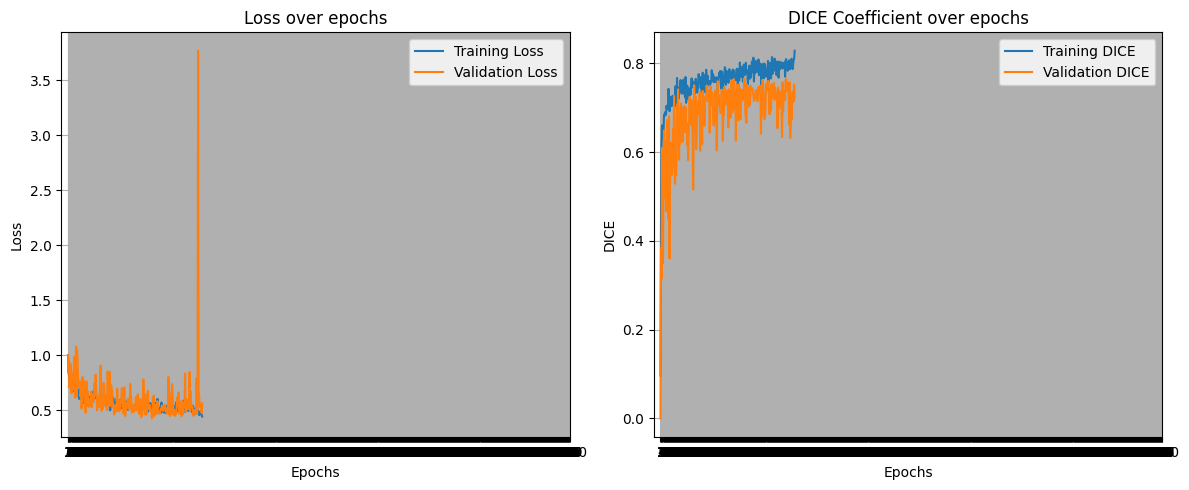

In [23]:
############### TRAINING EVOLUTION ###############

epochs_list = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()


plt.tight_layout()
plt.show()

## Model Evaluation

In [24]:
test_running_loss = 0
test_running_dc = 0

model.eval()

with torch.no_grad():
    for idx, (img, mask) in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img.float().to(device)
        mask = mask.to(device)  # Binary [B, H, W]

        y_pred = model(img)  # [B, 1, H, W]
        loss, dc = compute_loss_and_dice(y_pred, mask, criterion)  #Binary ver

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice Score: {test_dc:.4f}")


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.5412
Test Dice Score: 0.6985


## Saving the Model

In [25]:
model_ver="Gaza_1st_BestModel_70.pth"
torch.save(model.state_dict(), model_ver)

In [26]:
model_ver= "Gaza_1st_BestModel_70.pth"

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LOAD MODEL
model = UNetBinaryDetector().to(device)
model.load_state_dict(torch.load(model_ver, map_location=device))
model.eval()

UNetBinaryDetector(
  (encoder): ResNet(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [28]:
############### PATHS ###############
imagename = "hurricane-harvey_00000015"
pre_path = f"../data/processed/images/{imagename}_pre_disaster.png"
post_path = f"../data/processed/images/{imagename}_post_disaster.png"
original_mask_path = f"../data/processed/masks/{imagename}_post_disaster_mask.png"

In [42]:
imagename = "beit_hanoun_1_0"
pre_path = f"../data/filtered/data_secondary/split/test/images/{imagename}_pre_disaster.png"
post_path = f"../data/filtered/data_secondary/split/test/images/{imagename}_post_disaster.png"
original_mask_path = f"../data/filtered/data_secondary/split/test/masks/{imagename}_mask.png"

In [43]:
############### Same Transforms than training ###############
img_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485]*3 + [0.485]*3, std=[0.229]*3 + [0.229]*3)
])

In [44]:
threshold_pred=threshold ##best one till now is 

In [ ]:
def predict_image(pre_path, post_path):
    pre_img = Image.open(pre_path).convert("RGB")
    post_img = Image.open(post_path).convert("RGB")

    pre_tensor = transforms.ToTensor()(transforms.Resize((1024, 1024))(pre_img))
    post_tensor = transforms.ToTensor()(transforms.Resize((1024, 1024))(post_img))

    ################ MANUAL NORMALIZATION ###############
    pre_tensor = transforms.Normalize([0.485]*3, [0.229]*3)(pre_tensor)
    post_tensor = transforms.Normalize([0.485]*3, [0.229]*3)(post_tensor)

    input_tensor = torch.cat([pre_tensor, post_tensor], dim=0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = (torch.sigmoid(output) > threshold_pred).int()[0, 0]

    return pred_mask


In [46]:
############### PREDICT ###############
pred = predict_image(pre_path, post_path)
print("PIXELS DETECTED AS BUILDINGS:", pred.sum().item())

PIXELS DETECTED AS BUILDINGS: 105884


## Conversion of Output Mask to RGB .png File

In [47]:
pred_mask = predict_image(pre_path, post_path)

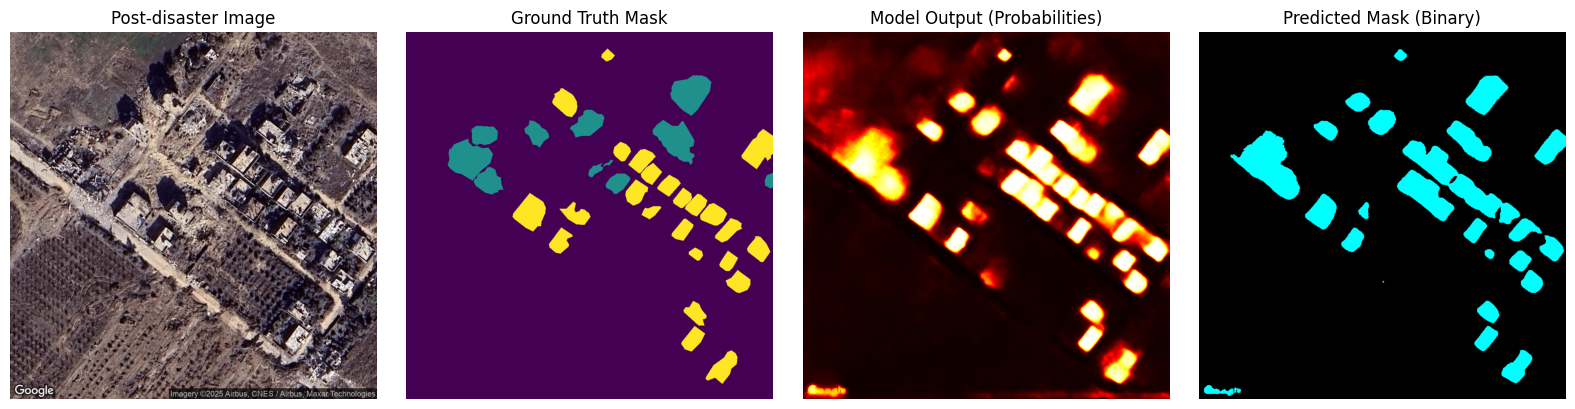

In [49]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T

# load and prepare images
pre_img = Image.open(pre_path).convert("RGB")
post_img = Image.open(post_path).convert("RGB")
mask_img = Image.open(original_mask_path)

# Resize
resize = T.Resize((1024, 1024))
pre_img = resize(pre_img)
post_img = resize(post_img)
mask_img = resize(mask_img)

# Tensor
pre_tensor = T.ToTensor()(pre_img)
post_tensor = T.ToTensor()(post_img)

# Concat y normalize
input_tensor = torch.cat([pre_tensor, post_tensor], dim=0)
normalize = T.Normalize(mean=[0.485]*6, std=[0.229]*6)
input_tensor = normalize(input_tensor).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    output = model(input_tensor)  # [1, 1, H, W]
    probs = torch.sigmoid(output)[0, 0]  # [H, W]
    pred_mask = (probs > 0.6).int()  #Adjust the threshold here if you need to

# Visualization 

def binary_mask_to_rgb(mask_tensor):
    mask_np = mask_tensor.cpu().numpy()
    rgb = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
    rgb[mask_np == 1] = (0, 255, 255)  # cyan
    return Image.fromarray(rgb)

plt.figure(figsize=(16, 4))

# Image post
plt.subplot(1, 4, 1)
plt.imshow(post_img)
plt.title("Post-disaster Image")
plt.axis("off")

# Ground truth
plt.subplot(1, 4, 2)
plt.imshow(mask_img, cmap="viridis")
plt.title("Ground Truth Mask")
plt.axis("off")

# Probab (hot map)
plt.subplot(1, 4, 3)
plt.imshow(probs.cpu(), cmap="hot")
plt.title("Model Output (Probabilities)")
plt.axis("off")

# binary pred
plt.subplot(1, 4, 4)
plt.imshow(binary_mask_to_rgb(pred_mask))
plt.title("Predicted Mask (Binary)")
plt.axis("off")

plt.tight_layout()
plt.show()


## RULL THROUGH ALL DATASET PREDICT AND SAVE IMAGES PREDICTION

In [52]:
model_ver="Gaza_1st_BestModel_70.pth"
threshold=0.6 #Gaza 0.6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LOAD MODEL
model_building = UNetBinaryDetector().to(device)
model_building.load_state_dict(torch.load(model_ver, map_location=device))
model_building.eval()

UNetBinaryDetector(
  (encoder): ResNet(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [53]:
def predict_building_mask(model, image_tensor):
    with torch.no_grad():
        logits = model(image_tensor.unsqueeze(0).to(device))  # [1, 1, H, W]
        probs = torch.sigmoid(logits.squeeze(0))              # [1, H, W]
        binary_mask = (probs > threshold).float()                   # threshold ajustable
        return binary_mask.cpu()

In [54]:
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import os
import torch
from tqdm import tqdm

def generate_building_masks(base_dataset, model_building, device, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    loader = DataLoader(base_dataset, batch_size=1, shuffle=False)

    model_building.eval()
    with torch.no_grad():
        for i, (img, _) in enumerate(tqdm(loader, desc=f"Generating {output_dir}")):
            img = img.to(device)
            pred = torch.sigmoid(model_building(img))
            bin_mask = (pred > 0.765).float().squeeze(0).squeeze(0)  # [H, W]

            mask_img = to_pil_image(bin_mask.cpu())
            image_id = base_dataset.ids[i]
            mask_img.save(os.path.join(output_dir, f"{image_id}_building_mask.png"))


splits = {
    "train": "../data/filtered/data_secondary/split/train",
    "val": "../data/filtered/data_secondary/split/val",
    "test": "../data/filtered/data_secondary/split/test"
}

for split_name, path in splits.items():
    dataset = SecondaryDataset(root_dir=path, mask_transform=mask_transform)
    output_dir = os.path.join(path, "building_masks")
    generate_building_masks(dataset, model_building, device, output_dir)


Generating ../data/filtered/data_secondary/split/train/building_masks:   0%|          | 0/101 [00:00<?, ?it/s]

Generating ../data/filtered/data_secondary/split/train/building_masks: 100%|██████████| 101/101 [01:41<00:00,  1.01s/it]
Generating ../data/filtered/data_secondary/split/val/building_masks: 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]
Generating ../data/filtered/data_secondary/split/test/building_masks: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
